<h1>Definitions</h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qiskit
from qiskit import IBMQ, Aer,QuantumCircuit, ClassicalRegister, QuantumRegister, transpile, assemble
from qiskit.quantum_info import Kraus, SuperOp
from qiskit_aer import AerSimulator
from qiskit.tools.visualization import plot_histogram
# Import from Qiskit Aer noise module
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

from qiskit_experiments.library import StateTomography
#!pip install cvxpy
import cvxpy

from mitiq.zne import execute_with_zne
from mitiq . zne . inference import AdaExpFactory
from mitiq . zne . inference import LinearFactory
from mitiq import zne

In [2]:
#!pip install mitiq
import mitiq

In [3]:
def noisem(prob_2q):
    #Create noise model
    noisemodel = NoiseModel()
    #Define times and probabilities
    prob_1q = 1-0.9969
    # prob_2q = 1-0.9773
    time_t1 = 10000*1e9
    time_t2 = 0.2*1e9
    time_1q = 0.00001*1e9
    time_2q = 0.0002*1e9
    time_measure = 0.00013*1e9
    time_reset = 0.00002*1e9
    #Define errors
    # error_reset = thermal_relaxation_error(time_t1, time_t2, time_reset)
    # error_meas = thermal_relaxation_error(time_t1, time_t2, time_measure)
    # error_1q  = thermal_relaxation_error(time_t1, time_t2, time_1q)
    # error_2q = thermal_relaxation_error(time_t1, time_t2, time_2q).expand(
    #              thermal_relaxation_error(time_t1, time_t2, time_2q))
    error_1 = depolarizing_error(prob_1q, 1)
    error_2 = depolarizing_error(prob_2q, 2)
    #Add errors to noise model
    # noisemodel.add_all_qubit_quantum_error(error_reset, "reset")
    # noisemodel.add_all_qubit_quantum_error(error_meas, "measure")
    # noisemodel.add_all_qubit_quantum_error(error_1q, ['h','rz'])
    # noisemodel.add_all_qubit_quantum_error(error_2q, ['cx'])
    noisemodel.add_all_qubit_quantum_error(error_1, ['h', 'rz'])
    noisemodel.add_all_qubit_quantum_error(error_2, ['cx'])
    basis_gates = noisemodel.basis_gates

    return noisemodel, basis_gates

In [4]:
# # Get basis gates from noise model
# basis_gates = noisemodel.basis_gates
# print(noisemodel)

In [5]:
def wrapper(noisemodel, basis_gates, circlogic,noisy_or_perfect,do_not_plot='false', **kwargs):
    if noisy_or_perfect=='perfect':
        return circlogic(None,None,do_not_plot,**kwargs)
    elif noisy_or_perfect=='noisy':
        return circlogic(basis_gates,noisemodel,do_not_plot,**kwargs)
    else:
        print('Wrong argument to noisy_or_perfect')

<h1>Markovian reservoir engineering</h1>

In [7]:
def zz_pump(q, c, p, system, ancilla, ini):
    z = QuantumCircuit(q, c)
    if ini == "01":
        z.x(q[system[0]])
    elif ini == "10":
        z.x(q[system[1]])
    elif ini == "11":
        z.x(q[system[0]])
        z.x(q[system[1]])
    
    z.cx(q[system[0]], q[system[1]])
    z.x(q[ancilla[0]])
    z.cx(q[system[1]], q[ancilla[0]])
    
    theta = 2 * np.arcsin(np.sqrt(p))
    
    z.cu(theta, 0.0, 0.0, 0.0, q[ancilla[0]], q[system[1]])
    
    z.cx(q[system[1]], q[ancilla[0]])
    #z.cx(q[system[0]], q[system[1]])
    z.h(q[system[0]])
    z.measure(q[system[0]], c[0])
    z.measure(q[system[1]], c[1])
    return z  

In [8]:
def zz_xx_pump(q, c, p, system, ancillae, ini):
    zx = QuantumCircuit(q, c)
    if ini == "01":
        zx.x(q[system[0]])
    elif ini == "10":
        zx.x(q[system[1]])
    elif ini == "11":
        zx.x(q[system[0]])
        zx.x(q[system[1]])
        
    zx.cx(q[system[0]], q[system[1]])
    zx.x(q[ancillae[0]])
    zx.cx(q[system[1]], q[ancillae[0]])
    
    theta = 2 * np.arcsin(np.sqrt(p))
    zx.cu(theta, 0.0, 0.0, 0.0, q[ancillae[0]], q[system[1]])
    
    zx.cx(q[system[1]], q[ancillae[0]])
    
    zx.h(q[system[0]])
    zx.x(q[ancillae[1]])
    zx.cx(q[system[0]], q[ancillae[1]])
    
    zx.cu(theta, 0.0, 0.0, 0.0, q[ancillae[1]], q[system[0]])
    
    zx.cx(q[system[0]], q[ancillae[1]])
    
    zx.measure(q[system[0]], c[0])
    zx.measure(q[system[1]], c[1])
    
    return zx

In [53]:
# Mitiq
linear_factory = LinearFactory ( scale_factors =[1.0 , 2.0 , 3.0])
def approx_theory_val_zz(basis_gates,noise_model, a, b, p,inis,zne, **kwargs):
    k=0
    
    for i in p:
        q = QuantumRegister(5, name='q')
        c = ClassicalRegister(2, name='c')
        circ = kwargs.get('pump')(q, c,i, [2,1], [0,4], inis)
        qq = circ
        def executor_j(j):
            def executor ( circ : mitiq.QPROGRAM) -> float:
                job = qiskit.execute(circ, Aer.get_backend('qasm_simulator'),basis_gates=basis_gates,noise_model=noise_model, shots=kwargs.get('shots'))
                counts = job.result().get_counts() 
                #return counts
                answer = {'00':0,'01':0,'10':0,'11':0}
                labels = list(answer.keys())
                for key,value in counts.items():
                    answer[key] = value
                return answer[labels[j]]/kwargs.get('shots')
            return executor
        for j in range(4):
            if kwargs.get('use_zne'):
                zne_value = execute_with_zne (circ, 
                                      executor_j(j), 
                                      scale_noise=zne.scaling.fold_global,
                                    factory = linear_factory)
                a[k][j] = zne_value
            else:
                a[k][j] = executor_j(j)(circ)
        k=k+1
        

    # Plotting
    for l in range(4):
        for m in range(len(p)):
            b[l][m] = b[l][m]+a[m][l]

In [76]:
def circ_markovian(basis_gates,noise_model,do_not_plot,**kwargs):
    # use local simulator
    zne1 = []
    shots = kwargs.get('shots')
    p = np.linspace(0,1.0,5)
    dict = {}
    a = [[0] * 4 for i in range(len(p))] #for each p, store counts for each type
    b = [[0] * len(p) for i in range(4)] #for each type, store counts for each p

    p2 = np.linspace(0,1.0,10)
    a2 =  [[0] * 4 for i in range(len(p2))]
    b2 = [[0] * len(p2) for i in range(4)]
    
    labels = ['00', '01', '10', '11']
    qq = None
    for inis in labels:
        approx_theory_val_zz(basis_gates,noise_model,a,b,p,inis, zne, pump=kwargs.get('pump'),shots=shots,use_zne=kwargs.get('use_zne'))
        approx_theory_val_zz(None,None,a2,b2,p2,inis, zne, pump=kwargs.get('pump'),shots=32768)
        # print(b)
    
    abserr = [abs(b[0][i]-b2[0][(len(p2)//len(p))*i])/4 for i in range(len(p))]
    if do_not_plot=='false':
        plt.title(kwargs.get('plot_title'))
        plt.plot(p2,(np.asarray(b2[0]))/4, linestyle='--')
        plt.plot(p2,(np.asarray(b2[1]))/4, linestyle='--')
        plt.plot(p2,(np.asarray(b2[2]))/4, linestyle='--')
        plt.plot(p2,(np.asarray(b2[3]))/4, linestyle='--')
        plt.scatter(p,(np.asarray(b[0]))/4, label="|phi+>")
        plt.scatter(p,(np.asarray(b[1]))/4,  label="|phi->")
        plt.scatter(p,(np.asarray(b[2]))/4,  label="|psi+>")
        plt.scatter(p,(np.asarray(b[3]))/4,  label="|psi->")
        plt.xlabel('Probability')
        plt.ylabel('Overlap')
        plt.legend()
        plt.show()
    return qq,abserr

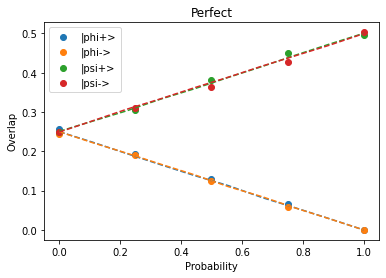

In [36]:
# ZZ
qq,_ = wrapper(None, None,circ_markovian,'perfect',plot_title='Perfect',shots=1024,pump=zz_pump)

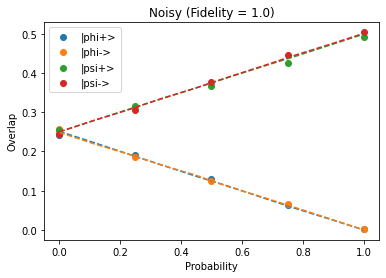

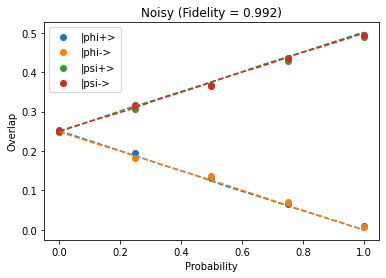

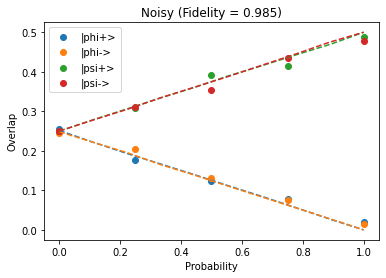

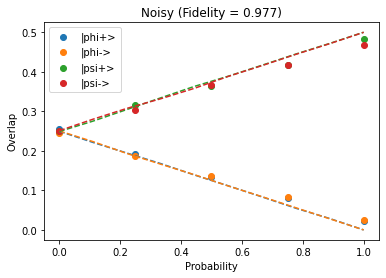

In [37]:
for i in np.linspace(0.0, 1-0.9773, num = 4):
    noisemodel, basis_gates = noisem(i)
    qq,_ = wrapper(noisemodel, basis_gates,circ_markovian,'noisy',plot_title=f'Noisy (Fidelity = {np.round(1-i, 3)})',shots=1024,pump=zz_pump)

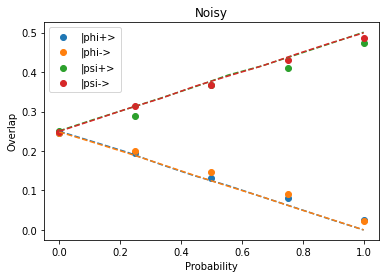

In [87]:
# ZZ
qq,abserr = wrapper(noisemodel, basis_gates,circ_markovian,'noisy',plot_title='Noisy',shots=1024,pump=zz_pump,use_zne=False)

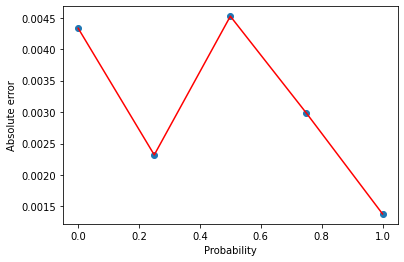

In [88]:
P = np.linspace(0.0,1.0,5)
plt.plot(P,abserr,c='red')
plt.scatter(P,abserr)
plt.xlabel('Probability')
plt.ylabel('Absolute error')
plt.show()

In [57]:
# ZZ_XX
qq = wrapper(noisemodel, basis_gates,circ_markovian,'noisy',plot_title='Noisy',shots=256,pump=zz_xx_pump,use_zne=True)

CircuitConversionError: Circuit could not be converted to an internal Mitiq circuit. This may be because the circuit contains custom gates or Pragmas (pyQuil). If you think this is a bug or that this circuit should be supported, you can open an issue at https://github.com/unitaryfund/mitiq. 

Provided circuit has type <class 'qiskit.circuit.quantumcircuit.QuantumCircuit'> and is:

     ┌───┐┌───┐                  ┌───┐                
q_0: ┤ X ├┤ X ├──────■───────────┤ X ├────────────────
     ├───┤└─┬─┘┌─────┴──────┐    └─┬─┘          ┌─┐   
q_1: ┤ X ├──■──┤ U(0,0,0,0) ├──────■────────────┤M├───
     └─┬─┘┌───┐└────────────┘┌────────────┐     └╥┘┌─┐
q_2: ──■──┤ H ├──────■───────┤ U(0,0,0,0) ├──■───╫─┤M├
          └───┘      │       └─────┬──────┘  │   ║ └╥┘
q_3: ────────────────┼─────────────┼─────────┼───╫──╫─
     ┌───┐         ┌─┴─┐           │       ┌─┴─┐ ║  ║ 
q_4: ┤ X ├─────────┤ X ├───────────■───────┤ X ├─╫──╫─
     └───┘         └───┘                   └───┘ ║  ║ 
c: 2/════════════════════════════════════════════╩══╩═
                                                 1  0 

Circuit types supported by Mitiq are 
{'cirq': 'Circuit', 'pyquil': 'Program', 'qiskit': 'QuantumCircuit', 'braket': 'Circuit', 'pennylane': 'QuantumTape'}.

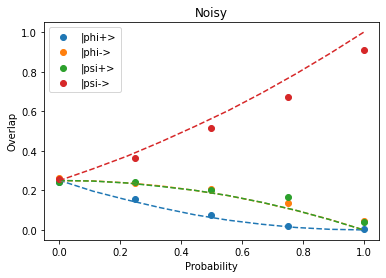

In [38]:
# ZZ_XX
qq = wrapper(noisemodel, basis_gates,circ_markovian,'noisy',plot_title='Noisy',shots=256,pump=zz_xx_pump)

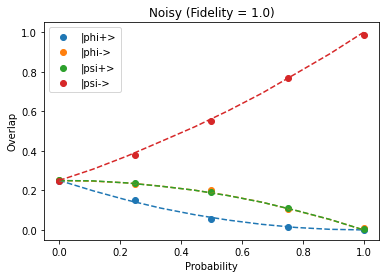

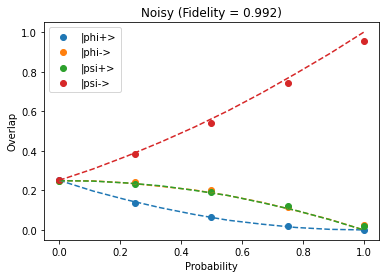

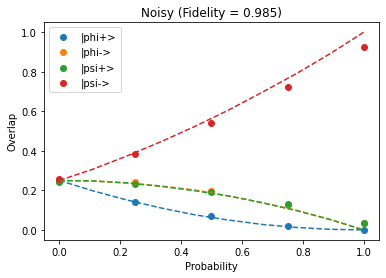

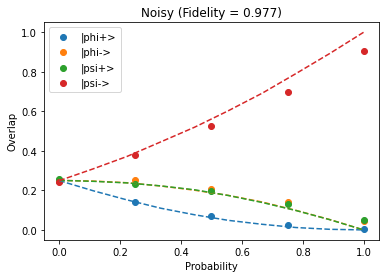

In [39]:
for i in np.linspace(0.0, 1-0.9773, num = 4):
    noisemodel, basis_gates = noisem(i)
    qq = wrapper(noisemodel, basis_gates,circ_markovian,'noisy',plot_title=f'Noisy (Fidelity = {np.round(1-i, 3)})',shots=1024,pump=zz_xx_pump)

<h1>Collisional model</h1>

<h2>Correlated case</h2>

In [6]:
def corr(q, c, system, ancillae, g, t, i):
    coA = QuantumCircuit(q,c)
    
    # State Preparation
    coA.h(q[system])
    coA.h(q[ancillae[2]])
    coA.cnot(q[ancillae[2]],q[ancillae[1]])
    coA.cnot(q[ancillae[2]],q[ancillae[0]])
    
    # Collisions between the system and ancilla qubits
    for j in range(1, i+1, 1):
        if j%2 != 0:
            coA.cnot(q[ancillae[0]],q[system])
            coA.rz(t, q[system])
            coA.cnot(q[ancillae[0]],q[system])
        else:
            coA.cnot(q[ancillae[1]],q[system])
            coA.rz(t, q[system])
            coA.cnot(q[ancillae[1]],q[system])
    
    coA.h(q[system])
    # op = qi.Operator(coA)
    # array = op.data
    # print(array)
    
    coA.measure(q[system],c[0])
        
    # return coA, array
    return coA

In [7]:
def circ_correlate(basis_gates,noise_model,do_not_plot,**kwargs):
    q = QuantumRegister(4,name = 'q')
    c = ClassicalRegister(1, name = 'c')
    system = 0
    ancillae = [1, 2, 3]
    rho_12, T = [], []
    n = kwargs.get('collisions')
    tt = np.pi/6
    g = 1
    t = g*(tt)
    numcx = []
    gatedepth = []
    pf = []
    def corrfunc(time):
        return (np.cos(time/2)**2-np.sin(time/2)**2)/2
    for i in range(1,n+1,1):
        circ = corr(q, c, system, ancillae, g, tt, i)
        numcx.append(circ.count_ops()['cx'])
        gatedepth.append(circ.depth())
        T.append(i*t)
        pf.append(corrfunc(i*t))
        job = qiskit.execute(circ, Aer.get_backend('qasm_simulator'),basis_gates=basis_gates,noise_model=noise_model, shots=kwargs.get('shots'))
        counts = job.result().get_counts()  
        rho_12.append((counts.get('0',0)-counts.get('1',0))/(2*(counts.get('0',0)+counts.get('1',0))))

    abserr = [abs(rho_12[i]-pf[i]) for i in range(len(numcx))]

    x_ax = np.linspace(0,T[-1],num=1000)
    if do_not_plot=='false':
        plt.scatter(T, np.real(rho_12),label='Simulation')
        plt.title(kwargs.get('plot_title'))
        plt.plot(x_ax,corrfunc(x_ax),linestyle='--',label='Theoretical')
        plt.legend()
        plt.show()
    return numcx,gatedepth,abserr, rho_12,pf

In [8]:
linear_factory = LinearFactory ( scale_factors =[1.0 , 2.0 , 3.0])
def corr_circ(basis_gates,noise_model,do_not_plot,**kwargs):
    q = QuantumRegister(4,name = 'q')
    c = ClassicalRegister(1, name = 'c')
    system = 0
    ancillae = [1, 2, 3]
    rho_12, T = [], []
    n = kwargs.get('collisions')
    tt = np.pi/6
    g = 1
    t = g*(tt)
    numcx = []
    gatedepth = []
    znee = []
    for i in range(1,n+1,1):
        circ = corr(q, c, system, ancillae, g, tt, i)
        numcx.append(circ.count_ops()['cx'])
        gatedepth.append(circ.depth())
        T.append(i*t)
        def executor ( circ : mitiq.QPROGRAM) -> float:
            #circ2 = corr(q, c, system, ancillae, g, tt, i)
            job = qiskit.execute(circ, Aer.get_backend('qasm_simulator'),basis_gates=basis_gates,noise_model=noise_model, shots=kwargs.get('shots'))
            counts = job.result().get_counts() 
            return (counts.get('0',0)-counts.get('1',0))/(2*(counts.get('0',0)+counts.get('1',0)))
        
        zne_value = execute_with_zne (circ, 
                              executor, 
                              scale_noise=zne.scaling.fold_global,
                            factory = linear_factory)
        znee.append(zne_value)
    return T,znee

In [9]:
# Mitigated
noisemodel, basis_gates = noisem(1-0.9773)
T,znee = wrapper(noisemodel, basis_gates, corr_circ,'perfect','true',shots=256,collisions=20)
print('*****')
print(znee)
# print(len(znee))

*****
[0.44531250000000017, 0.2708333333333336, -0.03255208333333335, -0.33854166666666674, -0.44921874999999994, -0.49999999999999983, -0.4440104166666667, -0.22656250000000014, 0.08333333333333334, 0.2187500000000001, 0.41666666666666685, 0.49999999999999983, 0.4440104166666668, 0.26041666666666663, -0.05208333333333334, -0.21614583333333345, -0.42057291666666696, -0.49999999999999983, -0.4505208333333335, -0.22265625000000008]


In [10]:
# Noise - Unmitigated
noisemodel, basis_gates = noisem(1-0.9773)
numcx,gatedepth,abserr, rho12,pf = wrapper(noisemodel, basis_gates, circ_correlate,'noisy','true',shots=256,collisions=20)
print('*****')
print(rho12)
print(len(rho12))

*****
[0.421875, 0.2578125, -0.04296875, -0.21875, -0.28125, -0.3671875, -0.28125, -0.12109375, 0.015625, 0.15234375, 0.24609375, 0.28125, 0.234375, 0.140625, -0.0078125, -0.1015625, -0.17578125, -0.21875, -0.16015625, -0.0703125]
20


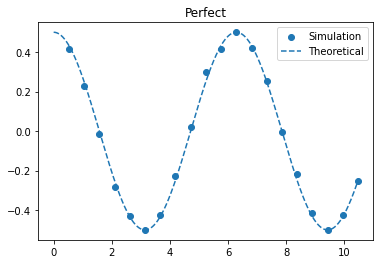

*****
[0.4140625, 0.23046875, -0.015625, -0.28125, -0.4296875, -0.5, -0.42578125, -0.2265625, 0.01953125, 0.30078125, 0.4140625, 0.5, 0.41796875, 0.25390625, -0.00390625, -0.21484375, -0.4140625, -0.5, -0.42578125, -0.25390625]
20


In [92]:
# No noise
noisemodel, basis_gates = noisem(1-0.9773)
numcx,gatedepth,abserr, znee, pf = wrapper(None, None, circ_correlate,'perfect',plot_title='Perfect',shots=256,collisions=20)
print('*****')
print(znee)
print(len(znee))

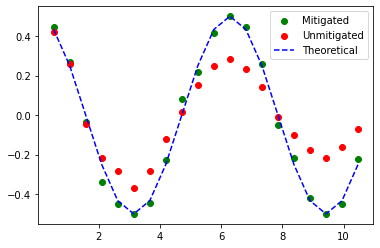

In [11]:
#print(len(T))
#print(len(znee))
#print(len(rho12))
plt.scatter(T,znee,c='green',label='Mitigated')
plt.scatter(T,rho12,c='red',label='Unmitigated')
plt.plot(T,pf,c='blue',linestyle='--',label='Theoretical')
plt.legend()
plt.show()

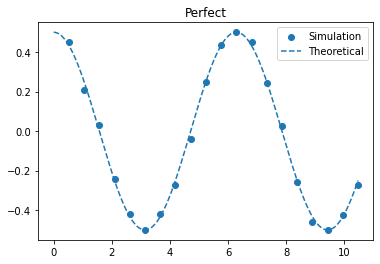

In [78]:
numcx,gatedepth,abserr, znee, pf = wrapper(None, None, circ_correlate,'perfect',plot_title='Perfect',shots=256,collisions=20)

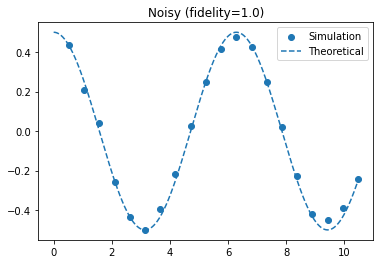

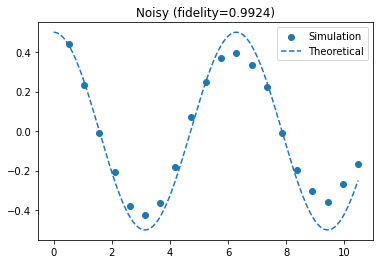

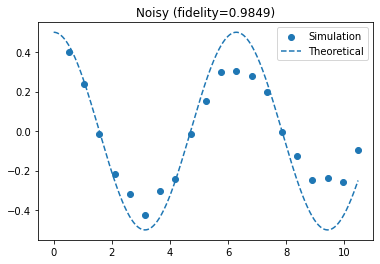

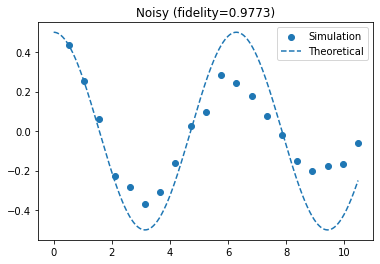

In [79]:
for i in np.linspace(0.0, 1-0.9773, num = 4):
    noisemodel, basis_gates = noisem(i)
    numcx,gatedepth,abserr, znee, pf = wrapper(noisemodel, basis_gates, circ_correlate,'noisy',plot_title=f'Noisy (fidelity={np.around(1-i,4)})',shots=256,collisions=20)

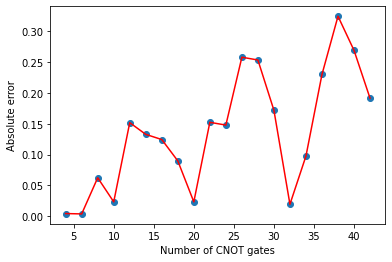

In [80]:
plt.plot(numcx,abserr,c='red')
plt.scatter(numcx,abserr)
plt.xlabel('Number of CNOT gates')
plt.ylabel('Absolute error')
plt.show()

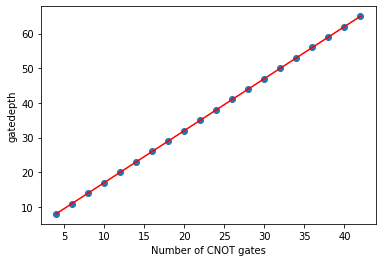

In [81]:
plt.plot(numcx,gatedepth,c='red')
plt.scatter(numcx,gatedepth)
plt.xlabel('Number of CNOT gates')
plt.ylabel('gatedepth')
plt.show()

In [82]:
shotsnum = np.array(range(256,2049,64))
noisemodel, basis_gates = noisem(1-0.9773)
meanerr = [np.mean(wrapper(noisemodel, basis_gates, circ_correlate,'noisy',do_not_plot='true',plot_title='Noisy',shots=shots,collisions=20)[2]) for shots in shotsnum]

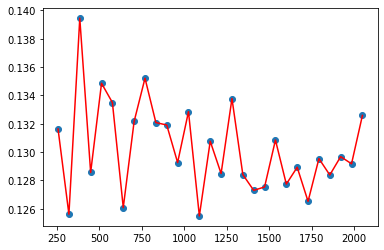

In [83]:
plt.scatter(shotsnum,meanerr)
plt.plot(shotsnum,meanerr,c='red')

<h2>Uncorrelated case</h2>

In [94]:
def uncorr(q, c, system, ancillae, g, t, i):
    ucoA = QuantumCircuit(q,c)
    ucoA.h(q[system])
    # State Preparation
    for l in range(i):
        ucoA.h(q[ancillae[l]])
    
    # Collisions between the system and ancilla qubits
    for j in range(1,i+1):
        ucoA.cnot(q[j],q[system])
        ucoA.rz(t, q[system])
        ucoA.cnot(q[j],q[system])
    
    ucoA.h(q[system])
    
    ucoA.measure(q[system],c[0])
        
    return ucoA

In [95]:
def circ_uncorrelate(basis_gates,noise_model,do_not_plot,**kwargs):
    n = kwargs.get('collisions')
    q = QuantumRegister(n+1,name = 'q')
    c = ClassicalRegister(1, name = 'c')
    system = 0
    ancillae = range(1,n+1)
    rho_12, T = [], []
    tt = np.pi/6
    g = 1
    t = g*(tt)
    numcx = []
    gatedepth = []
    for i in range(1,n+1,1):
        circ = uncorr(q, c, system, ancillae, g, 2*tt, i)
        numcx.append(circ.count_ops()['cx'])
        gatedepth.append(circ.depth())
        T.append(i*t)
        job = qiskit.execute(circ, Aer.get_backend('qasm_simulator'),basis_gates=basis_gates,noise_model=noise_model, shots=kwargs.get('shots'))
        counts = job.result().get_counts()   
        rho_12.append((counts.get('0',0)-counts.get('1',0))/(2*(counts.get('0',0)+counts.get('1',0))))

        
    def uncorrfunc(i):
        return np.power(np.cos(2*g*tt),i/t)/2
    
    abserr = [abs(rho_12[i]-uncorrfunc(T[i])) for i in range(len(numcx))]

    x_ax = np.linspace(0,T[-1],num=1000)
    if do_not_plot=='false':
        plt.title(kwargs.get('plot_title'))
        plt.scatter(T, np.real(rho_12),label='Simulation')
        plt.plot(x_ax,uncorrfunc(x_ax),linestyle='--',label='Theoretical')
        #plt.scatter(T, rho_12)
        plt.legend()
        plt.show()
    return numcx,gatedepth,abserr

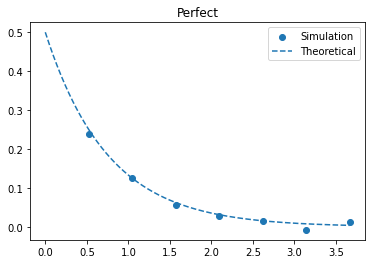

In [96]:
numcx,gatedepth,abserr = wrapper(None, None, circ_uncorrelate,'perfect',plot_title='Perfect',shots=1024,collisions=7)

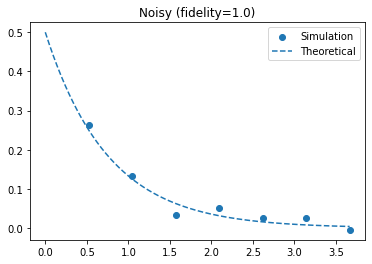

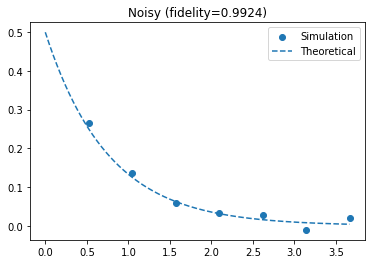

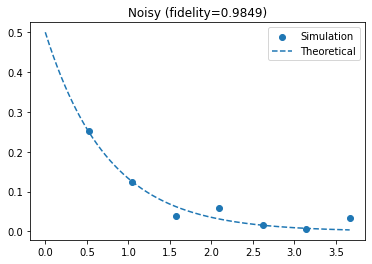

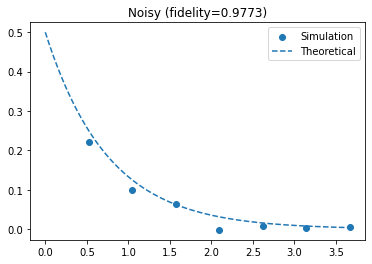

In [97]:
for i in np.linspace(0.0, 1-0.9773, num = 4):
    noisemodel, basis_gates = noisem(i)
    numcx,gatedepth,abserr = wrapper(noisemodel, basis_gates, circ_uncorrelate,'noisy',plot_title=f'Noisy (fidelity={np.around(1-i,4)})',shots=1024,collisions=7)

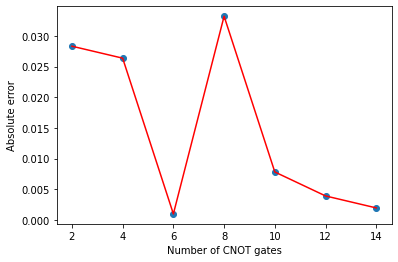

In [98]:
plt.plot(numcx,abserr,c='red')
plt.scatter(numcx,abserr)
plt.xlabel('Number of CNOT gates')
plt.ylabel('Absolute error')
plt.show()

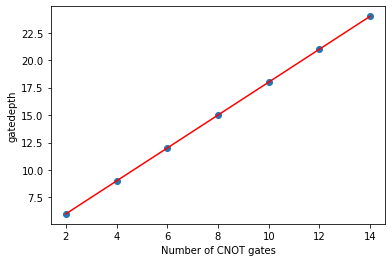

In [99]:
plt.plot(numcx,gatedepth,c='red')
plt.scatter(numcx,gatedepth)
plt.xlabel('Number of CNOT gates')
plt.ylabel('gatedepth')
plt.show()

In [100]:
shotsnum = np.array(range(256,2049,64))
noisemodel, basis_gates = noisem(1-0.9773)
meanerr = [np.mean(wrapper(noisemodel, basis_gates,circ_uncorrelate,'noisy',do_not_plot='true',plot_title='Noisy',shots=shots,collisions=7)[2]) for shots in shotsnum]

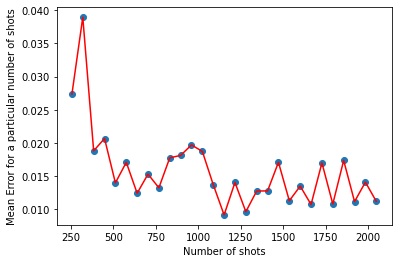

In [101]:
plt.scatter(shotsnum,meanerr)
plt.plot(shotsnum,meanerr,c='red')
plt.xlabel('Number of shots')
plt.ylabel('Mean Error for a particular number of shots')
plt.show()

<h1>Depolarizing channel</h1>

In [17]:
def depolarizing_channel(q, p, system, ancillae):
    """Returns a QuantumCircuit implementing depolarizing channel on q[system]
    
    Args:
        q (QuantumRegister): the register to use for the circuit
        p (float): the probability for the channel between 0 and 1
        system (int): index of the system qubit
        ancillae (list): list of indices for the ancillary qubits
        
    Returns:
        A QuantumCircuit object
    """
    z = QuantumCircuit(q)
    
    theta = 0.5*np.arccos(1-(2*p))
    
    t1 = np.pi/4
    t2 = np.pi/4
    
    z.ry(theta, q[ancillae[0]])
    z.ry(theta, q[ancillae[1]])
    z.ry(theta, q[ancillae[2]])
    
    z.ry(t1, q[system])
    z.rz(t2, q[system])
    
    z.cx(q[ancillae[0]], q[system])
    z.cy(q[ancillae[1]], q[system])
    z.cz(q[ancillae[2]], q[system])
    
    return z

In [18]:
phi = np.pi/4
psi = np.pi/4
a = np.cos(phi/2)**2
b = np.sin(phi/2)*np.cos(phi/2)*(np.cos(psi)-np.sin(psi)*1j)
c = np.conj(b)
d = np.sin(phi/2)**2

def theoretical_rho00(p):
    return 0.5*p+(1-p)*a
def theoretical_Rrho01(p):
    return np.real((1-p)*b)
def theoretical_Irho01(p):
    return np.imag((1-p)*b)
def theoretical_rho11(p):
    return 0.5*p+(1-p)*d

In [28]:
def circ_depol(basis_gates,noise_model,do_not_plot,**kwargs):
    p = np.linspace(0,1.0,10)
    q = QuantumRegister(5,name = 'q')
    system = 2
    ancillae = [1,3,4]
    rho11, rho22, Rrho12, Irho12, abser1, abser2, abser3, abser4 = [], [], [], [], [], [], [], []
    for i in p:
        circuit = depolarizing_channel(q, i, system, ancillae)
        # qst_bell = StateTomography(circuit, q[system])
        # job = qiskit.execute(qst_bell, Aer.get_backend('qasm_simulator'), shots=5000)
        # tomo_fitter_bell = StateTomographyFitter(job.result(), qst_bell)
        qstexp1 = StateTomography(circuit,measurement_qubits=[system])
        qstexp1.analysis.set_options(fitter='cvxpy_gaussian_lstsq')
        qstdata1 = qstexp1.run(Aer.get_backend('qasm_simulator'), basis_gates=basis_gates,noise_model=noise_model, shots=kwargs.get('shots'), seed_simulator=5000).block_for_results()
        state_result = qstdata1.analysis_results("state")

        rho = np.array(state_result.value)
        #print(rho)
        rho11.append(rho[0,0])
        rho22.append(rho[1,1])
        Rrho12.append(np.real(rho[0,1]))
        Irho12.append(np.imag(rho[0,1]))

    abser1 = [abs(rho11[i]-theoretical_rho00(p[i])) for i in range(len(p))]
    abser2 = [abs(rho22[i]-theoretical_rho11(p[i])) for i in range(len(p))]
    abser3 = [abs(Rrho12[i]-theoretical_Rrho01(p[i])) for i in range(len(p))]
    abser4 = [abs(Irho12[i]-theoretical_Irho01(p[i])) for i in range(len(p))]
   
    if do_not_plot=='false':
        plt.title(kwargs.get('plot_title'))
        plt.scatter(p, rho11, label="rho11")
        plt.scatter(p, rho22, label="rho22")
        plt.scatter(p, Rrho12, label="Rrho12")
        plt.scatter(p, Irho12, label="Irho12")
        plt.legend()
        plt.show()
        
    return abser1, abser2, abser3, abser4
    

/tmp/ipykernel_6336/153900155.py:12: DeprecationWarning: StateTomography.__init__ keyword argument measurement_qubits is deprecated and will be removed after Qiskit Experiments 0.5. It is now replaced with measurement_indices. 
  qstexp1 = StateTomography(circuit,measurement_qubits=[system])


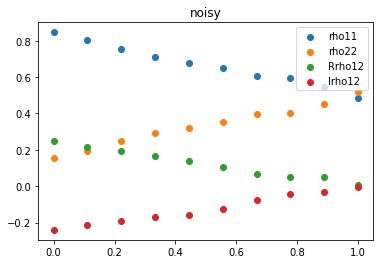

In [29]:
abser1, abser2, abser3, abser4 = wrapper(noisemodel, basis_gates,circ_depol,'noisy',plot_title='noisy',shots=1024)

In [30]:
shotsnum = np.array(range(256,2049,64))
noisemodel, basis_gates = noisem(1-0.9773)
meanerr = [np.mean(wrapper(noisemodel, basis_gates,circ_depol,'noisy',do_not_plot='true',plot_title='Noisy',shots=shots,collisions=7)[2]) for shots in shotsnum]

/tmp/ipykernel_6336/153900155.py:12: DeprecationWarning: StateTomography.__init__ keyword argument measurement_qubits is deprecated and will be removed after Qiskit Experiments 0.5. It is now replaced with measurement_indices. 
  qstexp1 = StateTomography(circuit,measurement_qubits=[system])


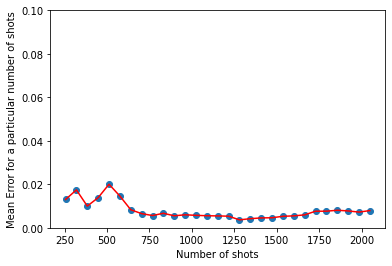

In [38]:
ax = plt.gca()
plt.scatter(shotsnum,meanerr)
plt.plot(shotsnum,meanerr,c='red')
plt.xlabel('Number of shots')
plt.ylabel('Mean Error for a particular number of shots')
ax.set_ylim([0,0.1])
plt.show()

In [50]:
shotsnum = np.array(range(256,2049,64))
noisemodel, basis_gates = noisem(1-0.9773)
meanerr = [np.mean(wrapper(noisemodel, basis_gates,circ_depol,'noisy',do_not_plot='true',plot_title='Noisy',shots=shots,collisions=7)[1]) for shots in shotsnum]

/tmp/ipykernel_6336/153900155.py:12: DeprecationWarning: StateTomography.__init__ keyword argument measurement_qubits is deprecated and will be removed after Qiskit Experiments 0.5. It is now replaced with measurement_indices. 
  qstexp1 = StateTomography(circuit,measurement_qubits=[system])


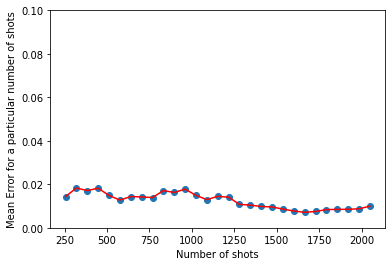

In [51]:
ax = plt.gca()
plt.scatter(shotsnum,meanerr)
plt.plot(shotsnum,meanerr,c='red')
plt.xlabel('Number of shots')
plt.ylabel('Mean Error for a particular number of shots')
ax.set_ylim([0,0.1])
plt.show()

In [52]:
shotsnum = np.array(range(256,2049,64))
noisemodel, basis_gates = noisem(1-0.9773)
meanerr = [np.mean(wrapper(noisemodel, basis_gates,circ_depol,'noisy',do_not_plot='true',plot_title='Noisy',shots=shots,collisions=7)[0]) for shots in shotsnum]

/tmp/ipykernel_6336/153900155.py:12: DeprecationWarning: StateTomography.__init__ keyword argument measurement_qubits is deprecated and will be removed after Qiskit Experiments 0.5. It is now replaced with measurement_indices. 
  qstexp1 = StateTomography(circuit,measurement_qubits=[system])


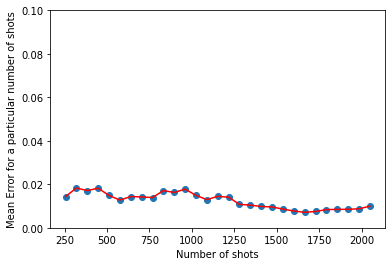

In [53]:
ax = plt.gca()
plt.scatter(shotsnum,meanerr)
plt.plot(shotsnum,meanerr,c='red')
plt.xlabel('Number of shots')
plt.ylabel('Mean Error for a particular number of shots')
ax.set_ylim([0,0.1])
plt.show()

/tmp/ipykernel_6336/153900155.py:12: DeprecationWarning: StateTomography.__init__ keyword argument measurement_qubits is deprecated and will be removed after Qiskit Experiments 0.5. It is now replaced with measurement_indices. 
  qstexp1 = StateTomography(circuit,measurement_qubits=[system])


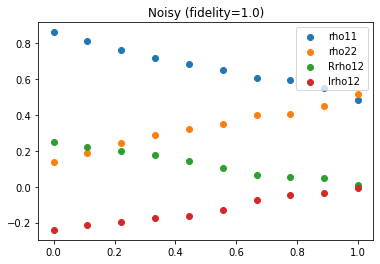

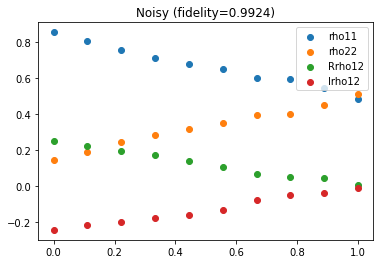

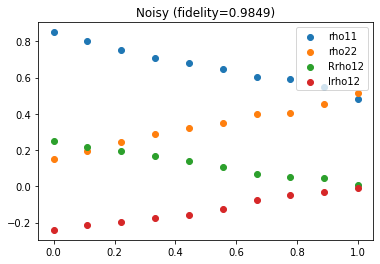

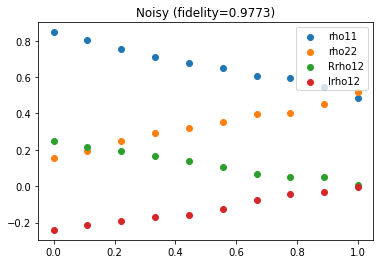

In [23]:
for i in np.linspace(0.0, 1-0.9773, num = 4):
    noisemodel, basis_gates = noisem(i)
    wrapper(noisemodel, basis_gates, circ_depol,'noisy',plot_title=f'Noisy (fidelity={np.around(1-i,4)})',shots=1024)